In [1]:
import os
import numpy as np
import pandas as pd
from itertools import chain

data_dir = '../result/GCN_fix_tree/SE/GCN_tree_diff/CRC'
outdir = '../result/predict'
if not os.path.exists(outdir):
    os.makedirs(outdir)
p_files = [os.path.join(data_dir, cohort, f'p_{cohort}.tsv') for cohort in os.listdir(data_dir)]

all_significant = []
for p_file in p_files:
    p_df = pd.read_csv(p_file, sep='\t')
    significant_clusters = p_df[p_df['p_adj'] < 0.05]['Unnamed: 0'].tolist()
    all_significant.append(significant_clusters)

significant_clusters = []
for cluster in set(chain(*all_significant)):
    if sum(cluster in s for s in all_significant) >= 2:
        significant_clusters.append(cluster)

print(f"Significant clusters: {significant_clusters}")

Significant clusters: ['cluster_S1-C4', 'supercluster_S2', 'cluster_S1-C1', 'cluster_S1-C5', 'cluster_C8', 'cluster_S2-C5', 'root', 'supercluster_S1', 'cluster_S1-C24', 'cluster_S1-C20']


In [2]:
import os
import pandas as pd

def get_cluster_data(data_dir):
    cluster_data = pd.DataFrame()
    
    for cohort_folder in os.listdir(data_dir):
        if cohort_folder.startswith('CRC'):
            cohort_path = os.path.join(data_dir, cohort_folder)
            
            crc_df = pd.read_csv(os.path.join(cohort_path, 'se_CRC.tsv'), sep='\t')
            crc_df['cohort'] = cohort_folder
            crc_df['label'] = 1
            crc_df = crc_df.rename(columns={'Unnamed: 0': 'sample'})
            
            health_df = pd.read_csv(os.path.join(cohort_path, 'se_Health.tsv'), sep='\t')
            health_df['cohort'] = cohort_folder
            health_df['label'] = 0
            health_df = health_df.rename(columns={'Unnamed: 0': 'sample'})
            

            cohort_data = pd.concat([crc_df, health_df], ignore_index=True)
            
            cluster_data = pd.concat([cluster_data, cohort_data], ignore_index=True)
    
    return cluster_data

cluster_df = get_cluster_data('../result/GCN_fix_tree/SE/GCN_tree_diff/CRC')
print(cluster_df.columns)

Index(['sample', 'cluster_S1-C1', 'cluster_S1-C2', 'cluster_S1-C3',
       'cluster_S1-C4', 'cluster_S1-C5', 'cluster_S1-C6', 'cluster_S1-C7',
       'cluster_S1-C8', 'cluster_S1-C9', 'cluster_S1-C10', 'cluster_S1-C11',
       'cluster_S1-C12', 'cluster_S1-C13', 'cluster_S1-C14', 'cluster_S1-C15',
       'cluster_S1-C16', 'cluster_S1-C17', 'cluster_S1-C18', 'cluster_S1-C19',
       'cluster_S1-C20', 'cluster_S1-C21', 'cluster_S1-C22', 'cluster_S1-C23',
       'cluster_S1-C24', 'cluster_S1-C25', 'cluster_S1-C26', 'cluster_S1-C27',
       'cluster_S1-C28', 'cluster_S2-C1', 'cluster_S2-C2', 'cluster_S2-C3',
       'cluster_S2-C4', 'cluster_S2-C5', 'cluster_S2-C6', 'cluster_S2-C7',
       'cluster_S2-C8', 'cluster_S3-C1', 'cluster_S3-C2', 'cluster_S3-C3',
       'cluster_S3-C4', 'cluster_S3-C5', 'cluster_S4-C1', 'cluster_S4-C2',
       'cluster_S4-C3', 'cluster_S4-C4', 'cluster_S5-C1', 'cluster_S5-C2',
       'cluster_S5-C3', 'cluster_S5-C4', 'cluster_S6-C1', 'cluster_S6-C2',
       'clust

In [3]:
cluster_df

,sample,cluster_S1-C1,cluster_S1-C2,cluster_S1-C3,cluster_S1-C4,cluster_S1-C5,cluster_S1-C6,cluster_S1-C7,cluster_S1-C8,cluster_S1-C9,...,cluster_C10,supercluster_S1,supercluster_S2,supercluster_S3,supercluster_S4,supercluster_S5,supercluster_S6,root,cohort,label
0,MG100152,2.240737,0.478341,0.001312,0.013922,0.049645,0.0,0.0,0.138859,0.220425,...,0.0,4.102845,0.284157,0.000000,0.0,0.000000,0.000000,4.557131,CRC1,1
1,MG100151,1.791097,0.013200,0.000000,0.000000,0.015254,0.0,0.0,0.107475,0.168127,...,0.0,3.189442,0.241673,0.000000,0.0,0.000000,0.002208,3.613718,CRC1,1
2,MG100150,0.561279,0.949763,0.000000,0.000000,0.052433,0.0,0.0,0.627809,0.002694,...,0.0,3.451796,0.041669,0.000000,0.0,0.000000,0.007775,3.541045,CRC1,1
3,MG100149,2.382629,0.075802,0.000000,0.000000,0.000000,0.0,0.0,0.069397,0.004507,...,0.0,2.972763,0.494738,0.028416,0.0,0.000000,0.000000,3.761063,CRC1,1
4,MG100148,1.012904,0.000000,0.000000,0.034377,0.027588,0.0,0.0,0.170509,0.470522,...,0.0,2.755078,0.787022,0.438007,0.0,0.000000,0.007121,4.234757,CRC1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215,CRC_MR_SBJ80H_17,1.158930,1.055963,0.059439,0.000623,0.800062,0.0,0.0,0.052333,0.052954,...,0.0,4.191041,0.454278,0.000000,0.0,0.000000,0.083579,4.944394,CRC9,0
1216,CRC_MR_SBJ81H_17,0.405553,0.323211,0.000000,0.002849,1.053332,0.0,0.0,0.078084,0.053548,...,0.0,2.798996,1.022416,0.010743,0.0,0.000000,0.146990,4.235571,CRC9,0
1217,CRC_MR_SBJ82H_17,1.227210,0.865587,0.000000,0.000000,0.983435,0.0,0.0,0.117748,0.027764,...,0.0,4.304784,0.187318,0.000000,0.0,0.000000,0.000646,4.638065,CRC9,0
1218,CRC_MR_SBJ83H_17,0.862560,0.757086,0.524800,0.002034,0.385075,0.0,0.0,0.002009,0.204279,...,0.0,4.118932,0.044933,0.011536,0.0,0.003056,0.151820,4.456783,CRC9,0


Excluding cohort: CRC1
Training data shape: (1165, 13)
Validation data shape: (55, 13)
Training AUC: 1.00
Validation AUC: 0.54


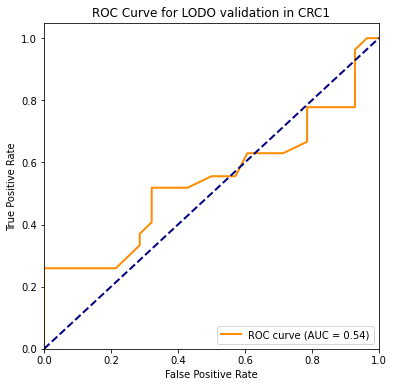


Excluding cohort: CRC2
Training data shape: (1160, 13)
Validation data shape: (60, 13)
Training AUC: 1.00
Validation AUC: 0.77


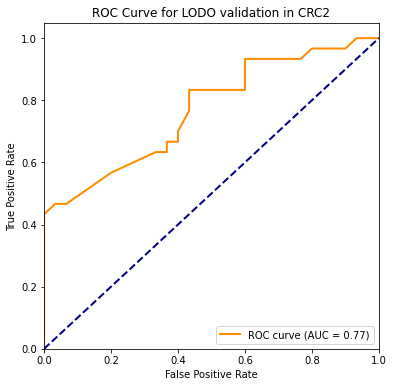


Excluding cohort: CRC3
Training data shape: (1140, 13)
Validation data shape: (80, 13)
Training AUC: 1.00
Validation AUC: 1.00


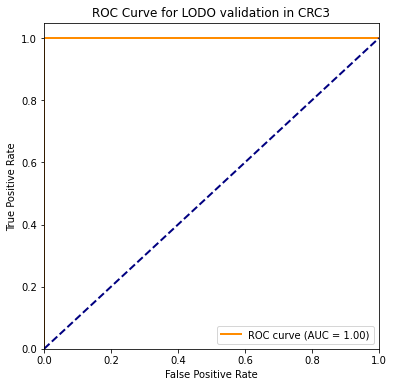


Excluding cohort: CRC4
Training data shape: (1137, 13)
Validation data shape: (83, 13)
Training AUC: 1.00
Validation AUC: 0.69


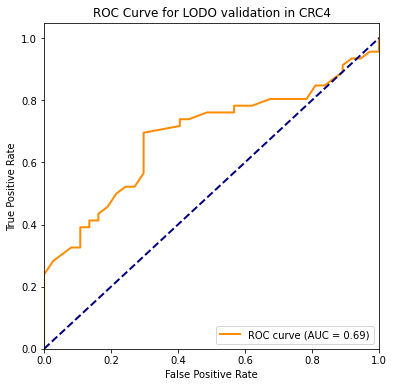


Excluding cohort: CRC5
Training data shape: (1110, 13)
Validation data shape: (110, 13)
Training AUC: 1.00
Validation AUC: 0.68


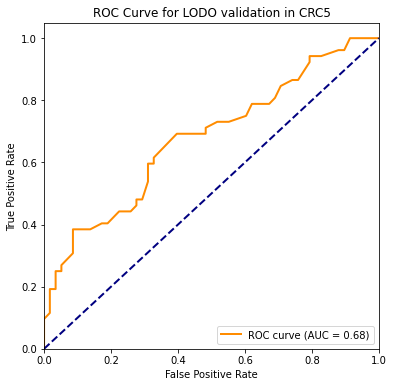


Excluding cohort: CRC6
Training data shape: (1106, 13)
Validation data shape: (114, 13)
Training AUC: 1.00
Validation AUC: 0.77


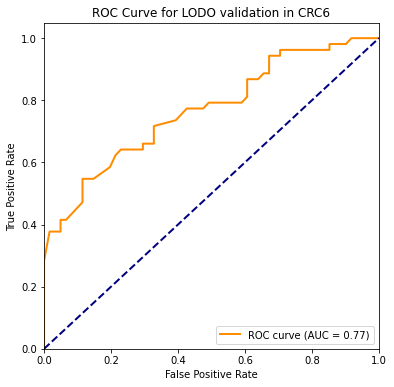


Excluding cohort: CRC7
Training data shape: (1095, 13)
Validation data shape: (125, 13)
Training AUC: 1.00
Validation AUC: 0.73


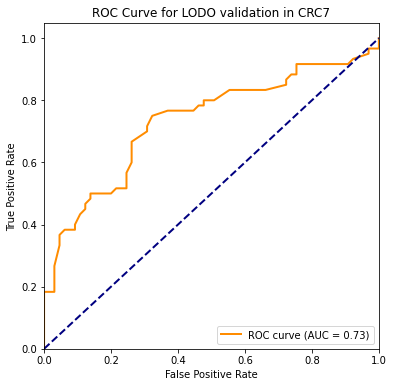


Excluding cohort: CRC8
Training data shape: (716, 13)
Validation data shape: (504, 13)
Training AUC: 1.00
Validation AUC: 0.72


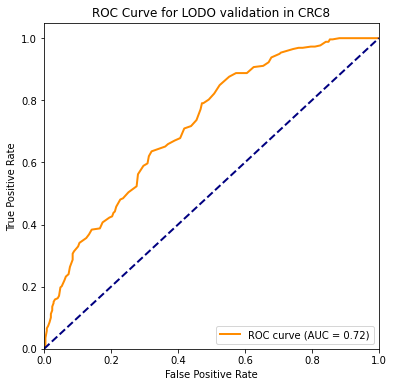


Excluding cohort: CRC9
Training data shape: (1131, 13)
Validation data shape: (89, 13)
Training AUC: 1.00
Validation AUC: 0.74


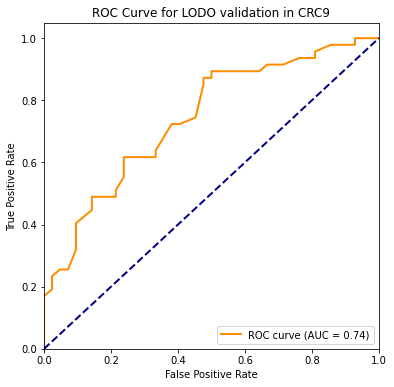


Feature Importance Sum:
cluster_S1-C20: 1.3354
supercluster_S1: 1.0346
root: 1.0279
cluster_S1-C5: 0.9517
supercluster_S2: 0.9239
cluster_S1-C1: 0.9188
cluster_C8: 0.8891
cluster_S2-C5: 0.7880
cluster_S1-C4: 0.7657
cluster_S1-C24: 0.3649
Validation AUC: 0.74 +/- 0.11


In [4]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

selected_columns = significant_clusters + ['sample', 'cohort', 'label']
#cluster_df = cluster_df[cluster_df['cohort'] != 'CRC1']
selected_df = cluster_df[selected_columns]

feature_importance_sum = {feature: 0 for feature in significant_clusters}

validation_auc_results = []

df = pd.DataFrame(columns=sorted(selected_df['cohort'].unique()), index=significant_clusters)
for exclude_cohort in [f'CRC{i}' for i in range(1, 10)]:
    print(f"Excluding cohort: {exclude_cohort}")
    
    train_df = selected_df[selected_df['cohort'] != exclude_cohort]
    val_df = selected_df[selected_df['cohort'] == exclude_cohort]
    
    print("Training data shape:", train_df.shape)
    print("Validation data shape:", val_df.shape)
    
    X_train = train_df[significant_clusters]
    y_train = train_df['label']
    
    rf = RandomForestClassifier(random_state=24)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict_proba(X_train)[:, 1]
    train_auc = roc_auc_score(y_train, y_pred)
    print(f"Training AUC: {train_auc:.2f}")

    X_val = val_df[significant_clusters]
    y_val = val_df['label']
    y_pred = rf.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, y_pred)
    print(f"Validation AUC: {val_auc:.2f}")

    fpr, tpr, _ = roc_curve(y_val, y_pred)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % val_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for LODO validation in {exclude_cohort}')
    plt.legend(loc="lower right")
    
    plt.savefig(os.path.join(outdir, '{}.recurrent.LODO.roc_curve.svg'.format(exclude_cohort)), format='svg')
    plt.show()
    
    for feature, importance in zip(significant_clusters, rf.feature_importances_):
        df.loc[feature, exclude_cohort] = importance
        feature_importance_sum[feature] += importance
    
    validation_auc_results.append(val_auc)
    
    print()

print("Feature Importance Sum:")
for feature, importance_sum in sorted(feature_importance_sum.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance_sum:.4f}")

print(f"Validation AUC: {np.mean(validation_auc_results):.2f} +/- {np.std(validation_auc_results):.2f}")

In [5]:
df.to_csv(os.path.join(outdir, 'feature_importance_sum.tsv'), sep='\t')